### Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/New_Alteration_zones

/content/drive/MyDrive/New_Alteration_zones


In [3]:
!pip install contextily
!pip install pyrsgis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.5 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import contextily as cx
from ipywidgets import interact
from math import floor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from pyrsgis import raster
from pyrsgis.ml import array_to_chips
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

### Training the model

In [5]:
%cd train_Landsat9/CNN_Landsat9

/content/drive/MyDrive/New_Alteration_zones/train_Landsat9/CNN_Landsat9


In [6]:
from numpy import load
train_x = load('train_x.npy')
train_y = load('train_y.npy')
test_x = load('test_x.npy')
test_y = load('test_y.npy')

In [7]:
def plot_metric(history, metric):    #For plotting any graph relating to any model
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

def plot_avg_AUC_ROC(y_pred, test_y, n_classes, label_names, figsize=(6.4, 4.8), average="macro"):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  #y_pred = model.predict(test_x, batch_size=64, verbose=1)
  y_test_dummies = pd.get_dummies(test_y, drop_first=False).values
  
  for i in range(n_classes):
    #fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i].astype(int) ,y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

      # roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic example')
  for i in range(n_classes):
      ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for {}'.format('{0:.2f}'.format(roc_auc[i]), label_names[i]))
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

def roc(model, test_x, test_y, n_classes):
  fpr = {}
  tpr = {}
  roc_auc = {}

  y_pred = model.predict(test_x, batch_size=64, verbose=1)
  y_test_dummies = pd.get_dummies(test_y, drop_first=False).values
  prediction = pd.get_dummies(y_pred.argmax(axis = 1),drop_first=False).values
  print(n_classes)
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


  return roc_auc

############## ORiginal Model Code ###################
def CNN_model(optimiser_type, experimental_runs, train_x, train_y, test_x, test_y):
  best_accuracy = 0
  best_model = tf.keras.models.Sequential()
  best_history = None

  columns = ['Accuracy', 'precision', 'recall', 'F1_score', "AUC_0", "AUC_1", "AUC_2", "Aggregate_AUC"]
  df = pd.DataFrame(columns = columns)

  for i in range(experimental_runs):
    #Model_name = "CNN_RMSPROP"

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimiser_type, metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs = 40, validation_data = (test_x, test_y))

    sum_y_pred = 0
    # predict for the test dataset
    yTestPredicted = model.predict(test_x)
    sum_y_pred = sum_y_pred + yTestPredicted
    # calculate and display error metrics
    yTestPredicted_ = yTestPredicted.argmax(axis=1)

    n_classes = 3
    Accuracy = accuracy_score(test_y, yTestPredicted_)
    cMatrix = confusion_matrix(test_y, yTestPredicted_)
    pScore = precision_score(test_y, yTestPredicted_, average='macro')
    rScore = recall_score(test_y, yTestPredicted_, average='macro')
    fscore = f1_score(test_y, yTestPredicted_, average='macro')

    #This function calculates all the evaluation metrics for every iteration
    roc_auc = roc(model, test_x, test_y, n_classes)
    result_array = [Accuracy, pScore, rScore, fscore]


    sum_of_roc_scores = 0
    for i in range(n_classes):
      result_array.append(roc_auc[i])
      sum_of_roc_scores = sum_of_roc_scores + roc_auc[i]

    aggregate_roc_score = sum_of_roc_scores/n_classes
    result_array.append(aggregate_roc_score)

    print("Confusion matrix:\n", cMatrix)
    print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))
    
    if best_accuracy < Accuracy:
      best_model = model
      best_accuracy = Accuracy
      best_history = history

    print(result_array)
    result_dict = {'Accuracy': Accuracy, 'precision': pScore, 'recall' : rScore, 'F1_score': fscore, "AUC_0": result_array[4]
                   , "AUC_1": result_array[5], "AUC_2": result_array[6], "Aggregate_AUC": result_array[7]}
    df = df.append(result_dict, ignore_index = True)
  print(df)
  return best_model, best_history, sum_y_pred/experimental_runs, df

Epoch 1/40
33/33 [==============================] - 2s 18ms/step - loss: 1.1181 - accuracy: 0.3381 - val_loss: 1.0736 - val_accuracy: 0.3400
Epoch 2/40
33/33 [==============================] - 0s 11ms/step - loss: 1.0801 - accuracy: 0.3952 - val_loss: 1.0266 - val_accuracy: 0.4400
Epoch 3/40
33/33 [==============================] - 0s 12ms/step - loss: 1.0033 - accuracy: 0.5219 - val_loss: 0.8691 - val_accuracy: 0.7600
Epoch 4/40
33/33 [==============================] - 0s 12ms/step - loss: 0.8668 - accuracy: 0.6457 - val_loss: 0.7116 - val_accuracy: 0.8133
Epoch 5/40
33/33 [==============================] - 0s 12ms/step - loss: 0.7802 - accuracy: 0.6924 - val_loss: 0.6061 - val_accuracy: 0.8578
Epoch 6/40
33/33 [==============================] - 0s 11ms/step - loss: 0.6551 - accuracy: 0.7810 - val_loss: 0.5202 - val_accuracy: 0.8289
Epoch 7/40
33/33 [==============================] - 0s 11ms/step - loss: 0.6072 - accuracy: 0.7733 - val_loss: 0.5723 - val_accuracy: 0.7467
Epoch 8/40
33

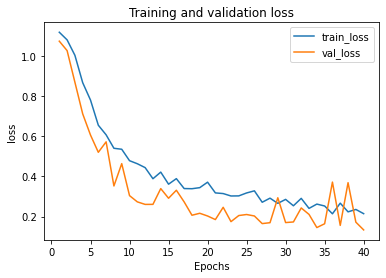

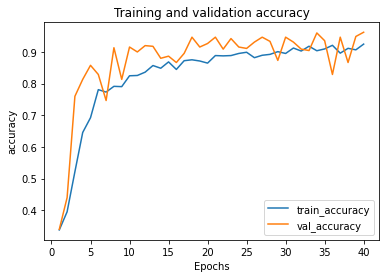

[[2.3145268e-03 3.0404339e-05 9.7655073e-02]
 [4.9275905e-04 9.9501863e-02 5.3590629e-06]
 [9.9120274e-02 6.4240041e-04 2.3731966e-04]
 ...
 [3.2192196e-03 2.1281737e-04 9.6567966e-02]
 [7.0879877e-02 1.4444023e-03 2.7675722e-02]
 [8.3079217e-03 1.1255683e-03 9.0566508e-02]]


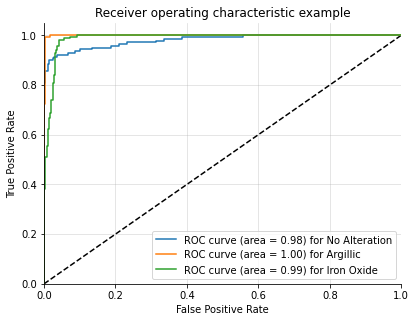

In [9]:
Model_name = 'CNN_RMSPROP'
NAME = 'Landsat9_DATA'
optimiser_type = 'rmsprop'
experimental_runs = 10

best_model, best_history, avg_y_pred, df = CNN_model(optimiser_type, experimental_runs, train_x, train_y, test_x, test_y)
df.to_csv('Results_{}_{}.csv'.format(NAME, Model_name))
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))
plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
label_names = ["No Alteration", "Argillic" , "Iron Oxide"]
print(avg_y_pred)
plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)

Epoch 1/40
33/33 [==============================] - 1s 15ms/step - loss: 1.0878 - accuracy: 0.3695 - val_loss: 1.0209 - val_accuracy: 0.5378
Epoch 2/40
33/33 [==============================] - 0s 11ms/step - loss: 0.9824 - accuracy: 0.5210 - val_loss: 0.8501 - val_accuracy: 0.6578
Epoch 3/40
33/33 [==============================] - 0s 10ms/step - loss: 0.8532 - accuracy: 0.6010 - val_loss: 0.7316 - val_accuracy: 0.7422
Epoch 4/40
33/33 [==============================] - 0s 10ms/step - loss: 0.7864 - accuracy: 0.6524 - val_loss: 0.6462 - val_accuracy: 0.7667
Epoch 5/40
33/33 [==============================] - 0s 10ms/step - loss: 0.7161 - accuracy: 0.6971 - val_loss: 0.5973 - val_accuracy: 0.7867
Epoch 6/40
33/33 [==============================] - 0s 11ms/step - loss: 0.6802 - accuracy: 0.7314 - val_loss: 0.5349 - val_accuracy: 0.8133
Epoch 7/40
33/33 [==============================] - 0s 10ms/step - loss: 0.6559 - accuracy: 0.7152 - val_loss: 0.5036 - val_accuracy: 0.8378
Epoch 8/40
33

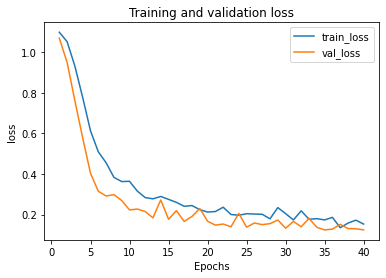

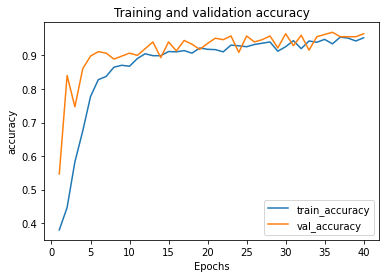

[[4.5749027e-04 2.1621256e-07 9.9542290e-02]
 [3.8571263e-04 9.9613823e-02 4.6186102e-07]
 [9.8369963e-02 8.2397350e-04 8.0606376e-04]
 ...
 [1.6169713e-03 1.7294373e-05 9.8365732e-02]
 [2.0325312e-02 7.4295553e-05 7.9600394e-02]
 [3.1254503e-03 3.6726247e-05 9.6837819e-02]]


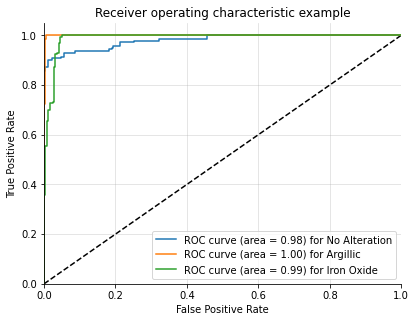

In [10]:
Model_name = 'CNN_ADAM'
NAME = 'Landsat9_DATA'
optimiser_type = 'adam'
experimental_runs = 10

best_model, best_history, avg_y_pred, df = CNN_model(optimiser_type, experimental_runs, train_x, train_y, test_x, test_y)
df.to_csv('Results_{}_{}.csv'.format(NAME, Model_name))
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))
plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
label_names = ["No Alteration", "Argillic" , "Iron Oxide"]
print(avg_y_pred)
plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)

Epoch 1/40
33/33 [==============================] - 1s 14ms/step - loss: 1.1168 - accuracy: 0.3486 - val_loss: 1.0967 - val_accuracy: 0.3311
Epoch 2/40
33/33 [==============================] - 0s 10ms/step - loss: 1.1016 - accuracy: 0.3533 - val_loss: 1.0907 - val_accuracy: 0.3489
Epoch 3/40
33/33 [==============================] - 0s 9ms/step - loss: 1.1029 - accuracy: 0.3238 - val_loss: 1.0874 - val_accuracy: 0.3911
Epoch 4/40
33/33 [==============================] - 0s 10ms/step - loss: 1.0962 - accuracy: 0.3771 - val_loss: 1.0852 - val_accuracy: 0.4356
Epoch 5/40
33/33 [==============================] - 0s 9ms/step - loss: 1.0927 - accuracy: 0.3705 - val_loss: 1.0828 - val_accuracy: 0.4622
Epoch 6/40
33/33 [==============================] - 0s 9ms/step - loss: 1.0914 - accuracy: 0.3638 - val_loss: 1.0790 - val_accuracy: 0.5556
Epoch 7/40
33/33 [==============================] - 0s 11ms/step - loss: 1.0865 - accuracy: 0.4048 - val_loss: 1.0749 - val_accuracy: 0.6289
Epoch 8/40
33/33

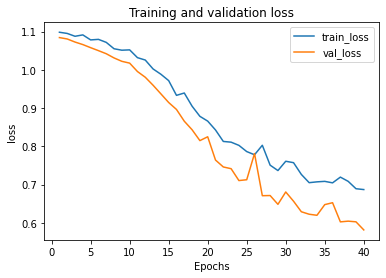

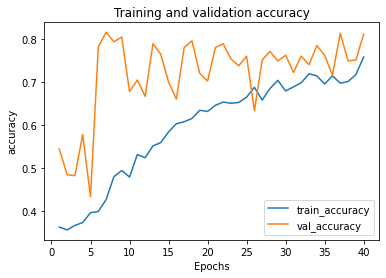

[[0.00202721 0.02731038 0.07066242]
 [0.01797434 0.05710931 0.02491635]
 [0.05548434 0.03099433 0.01352132]
 ...
 [0.00966885 0.03253725 0.05779392]
 [0.03402765 0.03925651 0.02671584]
 [0.00935841 0.03797182 0.05266977]]


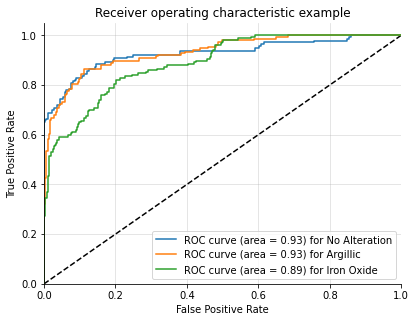

In [11]:
Model_name = 'CNN_SGD'
NAME = 'Landsat9_DATA'
optimiser_type = 'sgd'
experimental_runs = 10

best_model, best_history, avg_y_pred, df = CNN_model(optimiser_type, experimental_runs, train_x, train_y, test_x, test_y)
df.to_csv('Results_{}_{}.csv'.format(NAME, Model_name))
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))
plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
label_names = ["No Alteration", "Argillic" , "Iron Oxide"]
print(avg_y_pred)
plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)